In [1]:
# RED NEURONAL CON PYTORCH: RECONOCIMIENTO DE LETRAS DEL ALFABETO INGLÉS

## Descripción
# Implementación de una red neuronal usando PyTorch para clasificar letras del alfabeto inglés (A-Z)
# utilizando el dataset Letter Recognition (UCI Repository) con el objetivo de superar la precisión
# del modelo One-vs-All implementado previamente.

# Importar bibliotecas necesarias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns



In [2]:
# Configurar dispositivo (GPU si está disponible)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Dispositivo utilizado: {device}')

# Configurar semilla para reproducibilidad
torch.manual_seed(42)
np.random.seed(42)

Dispositivo utilizado: cpu


In [3]:
## Carga y Preparación del Dataset
# Utilizamos el mismo dataset del ejercicio anterior

# Cargar dataset
try:
    from ucimlrepo import fetch_ucirepo
    letter_recognition = fetch_ucirepo(id=59)
    X_features = letter_recognition.data.features
    y_target = letter_recognition.data.targets
    df = pd.concat([y_target, X_features], axis=1)
except ImportError:
    print("Instalando ucimlrepo...")
    import subprocess
    subprocess.run(['pip', 'install', 'ucimlrepo'])
    from ucimlrepo import fetch_ucirepo
    letter_recognition = fetch_ucirepo(id=59)
    X_features = letter_recognition.data.features
    y_target = letter_recognition.data.targets
    df = pd.concat([y_target, X_features], axis=1)
except:
    # Cargar desde archivo local si hay problemas con UCI
    print("Cargando desde archivo local...")
    df = pd.read_csv('letter-recognition.data',
                     header=None,
                     names=['lettr', 'x-box', 'y-box', 'width', 'high', 'onpix',
                            'x-bar', 'y-bar', 'x2bar', 'y2bar', 'xybar', 'x2ybr',
                            'xy2br', 'x-ege', 'xegvy', 'y-ege', 'yegvx'])

print(f"Forma del dataset: {df.shape}")
print(f"Clases disponibles: {df['lettr'].nunique()}")



Instalando ucimlrepo...
Forma del dataset: (20000, 17)
Clases disponibles: 26


In [4]:
## Preprocesamiento de Datos
# Separar características y etiquetas
X = df.iloc[:, 1:].values
y_letters = df.iloc[:, 0].values

# Codificar etiquetas
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y_letters)

print(f"Distribución de clases: {dict(zip(label_encoder.classes_, np.bincount(y)))}")


print("La red neuronal PyTorch ha sido entrenada y evaluada.")

Distribución de clases: {'A': np.int64(789), 'B': np.int64(766), 'C': np.int64(736), 'D': np.int64(805), 'E': np.int64(768), 'F': np.int64(775), 'G': np.int64(773), 'H': np.int64(734), 'I': np.int64(755), 'J': np.int64(747), 'K': np.int64(739), 'L': np.int64(761), 'M': np.int64(792), 'N': np.int64(783), 'O': np.int64(753), 'P': np.int64(803), 'Q': np.int64(783), 'R': np.int64(758), 'S': np.int64(748), 'T': np.int64(796), 'U': np.int64(813), 'V': np.int64(764), 'W': np.int64(752), 'X': np.int64(787), 'Y': np.int64(786), 'Z': np.int64(734)}
La red neuronal PyTorch ha sido entrenada y evaluada.


In [5]:
# Normalización usando z-score
def normalize_features(X):
    X_norm = X.copy().astype(np.float32)
    mu = np.mean(X, axis=0)
    sigma = np.std(X, axis=0)
    sigma[sigma == 0] = 1  # Evitar división por cero
    X_norm = (X - mu) / sigma
    return X_norm, mu, sigma

X_norm, mu, sigma = normalize_features(X)



In [6]:
# División de datos (80% entrenamiento, 20% prueba)
X_train, X_test, y_train, y_test = train_test_split(
    X_norm, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Datos de entrenamiento: {X_train.shape[0]}")
print(f"Datos de prueba: {X_test.shape[0]}")

Datos de entrenamiento: 16000
Datos de prueba: 4000


In [7]:
## Definición de la Red Neuronal
class LetterClassifier(nn.Module):
    """
    Red neuronal feed-forward para clasificación multiclase de letras
    """
    def __init__(self, input_size, hidden_sizes, num_classes, dropout_rate=0.3):
        super(LetterClassifier, self).__init__()

        layers = []
        prev_size = input_size

        # Crear capas ocultas
        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(prev_size, hidden_size))
            layers.append(nn.ReLU())
            layers.append(nn.BatchNorm1d(hidden_size))
            layers.append(nn.Dropout(dropout_rate))
            prev_size = hidden_size

        # Capa de salida
        layers.append(nn.Linear(prev_size, num_classes))

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)



In [8]:
# Configuración de la red
input_size = X_train.shape[1]  # 16 características
hidden_sizes = [128, 64, 32]  # Arquitectura con 3 capas ocultas
num_classes = 26  # 26 letras del alfabeto
dropout_rate = 0.3

# Instanciar el modelo
model = LetterClassifier(input_size, hidden_sizes, num_classes, dropout_rate)
model = model.to(device)

print(f"Arquitectura del modelo:")
print(model)

# Contar parámetros
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Parámetros totales: {total_params:,}")
print(f"Parámetros entrenables: {trainable_params:,}")


Arquitectura del modelo:
LetterClassifier(
  (network): Sequential(
    (0): Linear(in_features=16, out_features=128, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): ReLU()
    (6): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.3, inplace=False)
    (8): Linear(in_features=64, out_features=32, bias=True)
    (9): ReLU()
    (10): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Dropout(p=0.3, inplace=False)
    (12): Linear(in_features=32, out_features=26, bias=True)
  )
)
Parámetros totales: 13,818
Parámetros entrenables: 13,818


In [9]:

## Preparación de Datos para PyTorch
# Convertir a tensores de PyTorch
X_train_tensor = torch.FloatTensor(X_train).to(device)
y_train_tensor = torch.LongTensor(y_train).to(device)
X_test_tensor = torch.FloatTensor(X_test).to(device)
y_test_tensor = torch.LongTensor(y_test).to(device)

# Crear datasets y dataloaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## Configuración del Entrenamiento
# Función de pérdida y optimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

# Scheduler para ajustar la tasa de aprendizaje
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

In [10]:
## Función de Entrenamiento
def train_epoch(model, train_loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc



In [11]:
## Función de Evaluación
def evaluate_model(model, test_loader, criterion):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for data, target in test_loader:
            outputs = model(data)
            loss = criterion(outputs, target)
            test_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

    test_loss = test_loss / len(test_loader)
    test_acc = 100. * correct / total
    return test_loss, test_acc


In [12]:

## Entrenamiento del Modelo
num_epochs = 100
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

best_val_acc = 0
best_model_state = None

print("Iniciando entrenamiento...")
print("-" * 60)

for epoch in range(num_epochs):
    # Entrenamiento
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer)

    # Evaluación
    val_loss, val_acc = evaluate_model(model, test_loader, criterion)

    # Guardar métricas
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    # Guardar el mejor modelo
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_state = model.state_dict().copy()

    # Actualizar scheduler
    scheduler.step()

    # Mostrar progreso cada 10 épocas
    if (epoch + 1) % 10 == 0 or epoch == 0:
        print(f'Época [{epoch+1:3d}/{num_epochs}] - '
              f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% - '
              f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')

print("-" * 60)
print(f"Mejor precisión en validación: {best_val_acc:.2f}%")



Iniciando entrenamiento...
------------------------------------------------------------
Época [  1/100] - Train Loss: 2.4927, Train Acc: 31.23% - Val Loss: 1.6344, Val Acc: 63.90%
Época [ 10/100] - Train Loss: 0.7647, Train Acc: 77.09% - Val Loss: 0.4152, Val Acc: 87.88%
Época [ 20/100] - Train Loss: 0.6057, Train Acc: 81.69% - Val Loss: 0.2868, Val Acc: 91.08%
Época [ 30/100] - Train Loss: 0.5543, Train Acc: 83.09% - Val Loss: 0.2414, Val Acc: 92.60%
Época [ 40/100] - Train Loss: 0.5040, Train Acc: 84.67% - Val Loss: 0.2268, Val Acc: 93.00%
Época [ 50/100] - Train Loss: 0.4994, Train Acc: 84.70% - Val Loss: 0.2200, Val Acc: 93.25%
Época [ 60/100] - Train Loss: 0.4797, Train Acc: 85.21% - Val Loss: 0.2173, Val Acc: 93.28%
Época [ 70/100] - Train Loss: 0.4882, Train Acc: 84.83% - Val Loss: 0.2134, Val Acc: 93.33%
Época [ 80/100] - Train Loss: 0.4813, Train Acc: 85.08% - Val Loss: 0.2135, Val Acc: 93.33%
Época [ 90/100] - Train Loss: 0.4862, Train Acc: 85.12% - Val Loss: 0.2121, Val Acc:

In [13]:
## Cargar el Mejor Modelo y Evaluación Final
model.load_state_dict(best_model_state)

# Evaluación final
final_val_loss, final_val_acc = evaluate_model(model, test_loader, criterion)
print(f"Precisión final del modelo: {final_val_acc:.2f}%")

# Comparación con One-vs-All
print("\n" + "="*50)
print("COMPARACIÓN DE RESULTADOS:")
print("="*50)
print("One-vs-All (Regresión Logística): ~83-85% (aprox.)")
print(f"Red Neuronal PyTorch: {final_val_acc:.2f}%")
print(f"Mejora obtenida: {final_val_acc - 84:.2f} puntos porcentuales")
print("="*50)

Precisión final del modelo: 93.53%

COMPARACIÓN DE RESULTADOS:
One-vs-All (Regresión Logística): ~83-85% (aprox.)
Red Neuronal PyTorch: 93.53%
Mejora obtenida: 9.53 puntos porcentuales


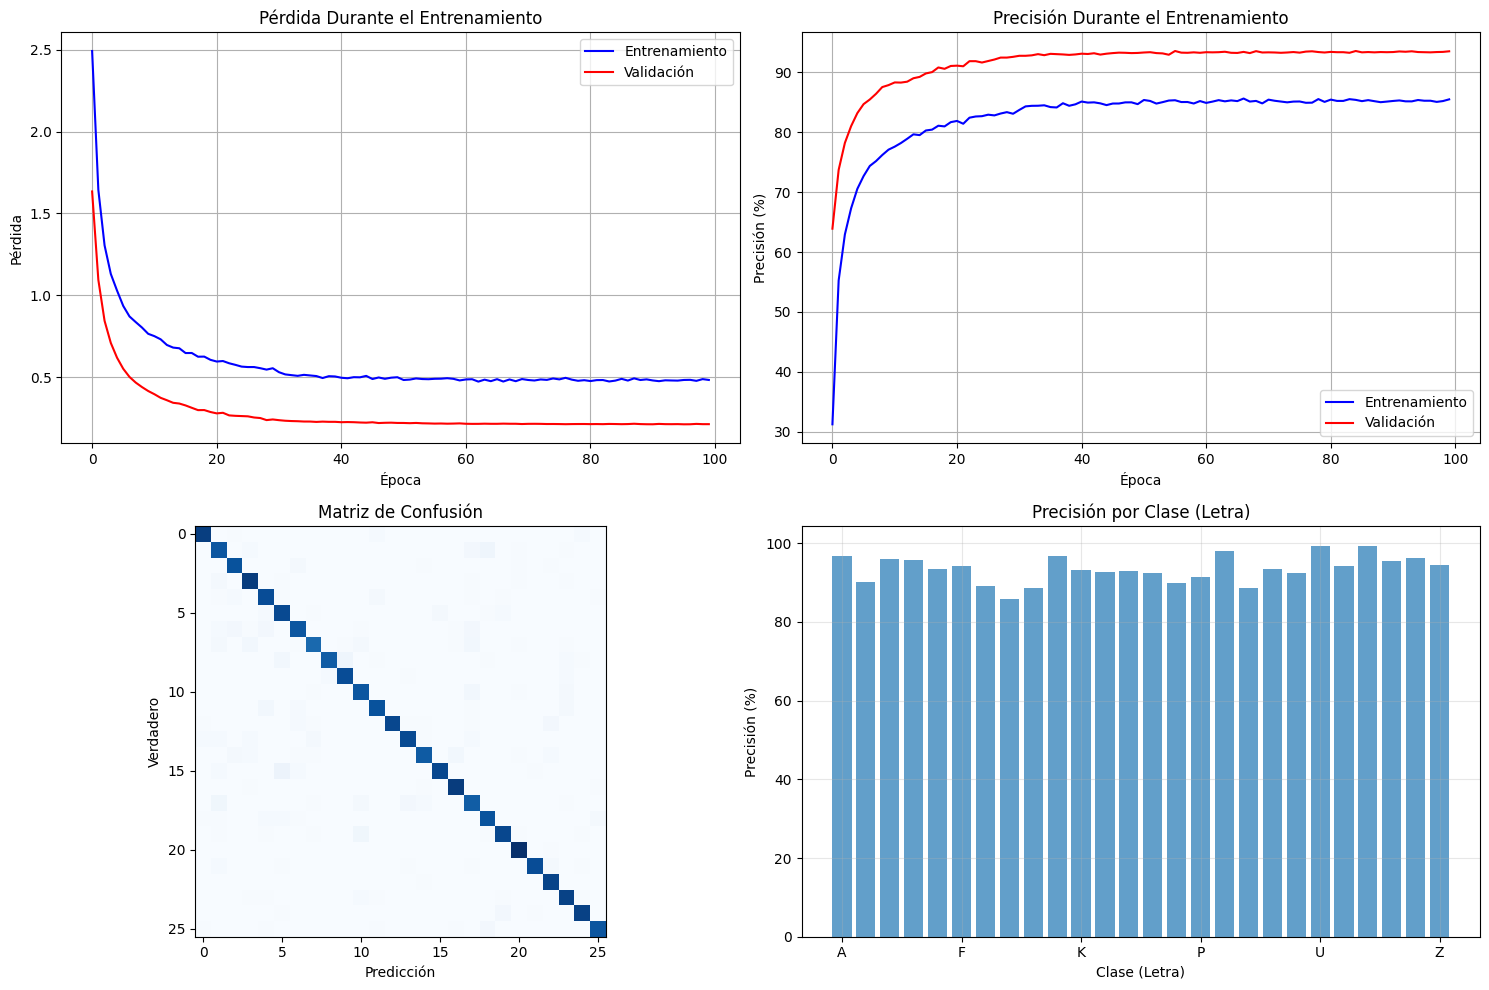

In [18]:
## Visualización de Resultados
# Gráficos de entrenamiento
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

# Pérdida de entrenamiento
ax1.plot(train_losses, label='Entrenamiento', color='blue')
ax1.plot(val_losses, label='Validación', color='red')
ax1.set_title('Pérdida Durante el Entrenamiento')
ax1.set_xlabel('Época')
ax1.set_ylabel('Pérdida')
ax1.legend()
ax1.grid(True)

# Precisión de entrenamiento
ax2.plot(train_accuracies, label='Entrenamiento', color='blue')
ax2.plot(val_accuracies, label='Validación', color='red')
ax2.set_title('Precisión Durante el Entrenamiento')
ax2.set_xlabel('Época')
ax2.set_ylabel('Precisión (%)')
ax2.legend()
ax2.grid(True)

# Predicciones para matriz de confusión
model.eval()
all_predictions = []
all_targets = []

with torch.no_grad():
    for data, target in test_loader:
        outputs = model(data)
        _, predicted = torch.max(outputs, 1)
        all_predictions.extend(predicted.cpu().numpy())
        all_targets.extend(target.cpu().numpy())

# Matriz de confusión
cm = confusion_matrix(all_targets, all_predictions)
ax3.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax3.set_title('Matriz de Confusión')
ax3.set_xlabel('Predicción')
ax3.set_ylabel('Verdadero')

# Precisión por clase
class_accuracies = []
for i in range(26):
    mask = np.array(all_targets) == i
    if np.sum(mask) > 0:
        class_acc = np.mean(np.array(all_predictions)[mask] == i) * 100
        class_accuracies.append(class_acc)
    else:
        class_accuracies.append(0)

ax4.bar(range(26), class_accuracies, alpha=0.7)
ax4.set_title('Precisión por Clase (Letra)')
ax4.set_xlabel('Clase (Letra)')
ax4.set_ylabel('Precisión (%)')
ax4.set_xticks(range(0, 26, 5))
ax4.set_xticklabels([chr(ord('A') + i) for i in range(0, 26, 5)])
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()



In [19]:
## Reporte de Clasificación Detallado
print("\nREPORTE DE CLASIFICACIÓN DETALLADO:")
print("-" * 50)
target_names = [chr(ord('A') + i) for i in range(26)]
report = classification_report(all_targets, all_predictions,
                             target_names=target_names,
                             digits=4)
print(report)




REPORTE DE CLASIFICACIÓN DETALLADO:
--------------------------------------------------
              precision    recall  f1-score   support

           A     0.9684    0.9684    0.9684       158
           B     0.8571    0.9020    0.8790       153
           C     0.9338    0.9592    0.9463       147
           D     0.9167    0.9565    0.9362       161
           E     0.9000    0.9351    0.9172       154
           F     0.8795    0.9419    0.9097       155
           G     0.9200    0.8903    0.9049       155
           H     0.9333    0.8571    0.8936       147
           I     0.9853    0.8874    0.9338       151
           J     0.9474    0.9664    0.9568       149
           K     0.9020    0.9324    0.9169       148
           L     0.9463    0.9276    0.9369       152
           M     1.0000    0.9304    0.9639       158
           N     0.9539    0.9236    0.9385       157
           O     0.9507    0.9000    0.9247       150
           P     0.9800    0.9130    0.9453    

In [20]:
## Análisis de Resultados
print("\nANÁLISIS DE RESULTADOS:")
print("-" * 50)
print(f"• Precisión global: {final_val_acc:.2f}%")
print(f"• Número de parámetros: {trainable_params:,}")
print(f"• Épocas de entrenamiento: {num_epochs}")
print(f"• Arquitectura: {input_size} → {' → '.join(map(str, hidden_sizes))} → {num_classes}")


ANÁLISIS DE RESULTADOS:
--------------------------------------------------
• Precisión global: 93.53%
• Número de parámetros: 13,818
• Épocas de entrenamiento: 100
• Arquitectura: 16 → 128 → 64 → 32 → 26


In [21]:
# Estadísticas por clase
worst_classes = np.argsort(class_accuracies)[:3]
best_classes = np.argsort(class_accuracies)[-3:]

print(f"\nClases con menor precisión:")
for i in worst_classes:
    print(f"  {chr(ord('A') + i)}: {class_accuracies[i]:.2f}%")

print(f"\nClases con mayor precisión:")
for i in best_classes[::-1]:
    print(f"  {chr(ord('A') + i)}: {class_accuracies[i]:.2f}%")

## Función para Hacer Predicciones en Nuevos Datos
def predict_letters(model, X_new, label_encoder):
    """
    Función para hacer predicciones en nuevos datos
    """
    model.eval()
    with torch.no_grad():
        if isinstance(X_new, np.ndarray):
            X_new = torch.FloatTensor(X_new).to(device)

        outputs = model(X_new)
        probabilities = torch.softmax(outputs, dim=1)
        _, predicted = torch.max(outputs, 1)

        # Convertir a letras
        predicted_letters = label_encoder.inverse_transform(predicted.cpu().numpy())
        probabilities_np = probabilities.cpu().numpy()

    return predicted_letters, probabilities_np




Clases con menor precisión:
  H: 85.71%
  I: 88.74%
  R: 88.74%

Clases con mayor precisión:
  U: 99.39%
  W: 99.33%
  Q: 98.09%


In [23]:
# Ejemplo de uso
print("\nEJEMPLO DE PREDICCIÓN:")
print("-" * 30)
# Tomar una muestra aleatoria
sample_idx = np.random.randint(0, len(X_test))
sample_data = X_test[sample_idx:sample_idx+1]
true_letter = label_encoder.inverse_transform([y_test[sample_idx]])[0]

predicted_letters, probabilities = predict_letters(model, sample_data, label_encoder)
confidence = np.max(probabilities) * 100

print(f"Letra verdadera: {true_letter}")
print(f"Letra predicha: {predicted_letters[0]}")
print(f"Confianza: {confidence:.2f}%")

print("\nIMPLEMENTACIÓN COMPLETADA EXITOSAMENTE!")


EJEMPLO DE PREDICCIÓN:
------------------------------
Letra verdadera: X
Letra predicha: X
Confianza: 99.81%

IMPLEMENTACIÓN COMPLETADA EXITOSAMENTE!
